# Introduction

In this notebook, we attempt to determine the "best" neighborhood in Pittsburgh. In order to make this determination, we decided to try and find the safest neighborhood in Pittsburgh, which we believe is an important metric for anyone who wants to live or rent in the Pittsburgh area.

# The Metric

In order to measure our overall metric of safety, we combined the sub-metrics of number of the arrests per neighborhood taken from WPRDC's [Pittsburgh Police Arrest Data](https://data.wprdc.org/dataset/arrest-data) dataset and the number of police incidents per neighborhood taken from WPRDC's [Police Incident Blotter (30 Day)](https://data.wprdc.org/dataset/police-incident-blotter) dataset -- both standardized to the same 30-day timeframe -- to make a data-driven determination of the safest neighborhood in Pittsburgh.

# The Best Neighborhood

We performed the following data analysis steps to determine the safest neighorhood in Pittsburgh. First, we will import the necessary Python packages:

In [1]:
# import packages

#!pip install geopandas
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline
import matplotlib.pyplot as plt

Next, we will import and process the datasets:

In [21]:
# read in dataset and parse dates as DateTime objects
arrests = pd.read_csv("police_arrest_data.csv", parse_dates=["ARRESTTIME"])

# drop observations that have null values in the INCIDENTNEIGHBORHOOD column
arrests = arrests.dropna(subset=['INCIDENTNEIGHBORHOOD'])

# filter arrests data to dates consistent with the other, 30-day dataframe
start_date = pd.to_datetime('2023-03-10')
end_date = pd.to_datetime('2023-04-06')

filtered_arrests = arrests[(arrests['ARRESTTIME'] >= start_date) & (arrests['ARRESTTIME'] <= end_date)]

In [13]:
# read in dataset
blotter = pd.read_csv("police_incident_blotter_data.csv")

# drop observations that have null values in the INCIDENTNEIGHBORHOOD column
blotter = blotter.dropna(subset=['INCIDENTNEIGHBORHOOD'])

In [15]:
# merge the two datasets
merged_df = blotter.merge(filtered_arrests, how='left', left_on='INCIDENTNEIGHBORHOOD', right_on='INCIDENTNEIGHBORHOOD')

Each incident in the `blotter` dataset has a `HIERARCHY` value associated with it, with more severe incident having a higher `HIERARCHY` value. For example, a parking violation has a very low `HIERARCHY` value, while a missing person report has a very high `HIERARCHY` value. Thus, we sum the `HIERARCHY` values within each neighborhood to get a more nuanced measure of neighborhood safety than number of incidents alone.

In [19]:
# count the number of arrests per neighborhood
num_arrests = filtered_arrests.groupby("INCIDENTNEIGHBORHOOD").count()["OFFENSES"].sort_values(ascending=True)

# sum the hierarchy of all the events for each neighborhood
rank = nb.sum()['HIERARCHY'].sort_values(ascending=True)

We can now plot each sub-metric:

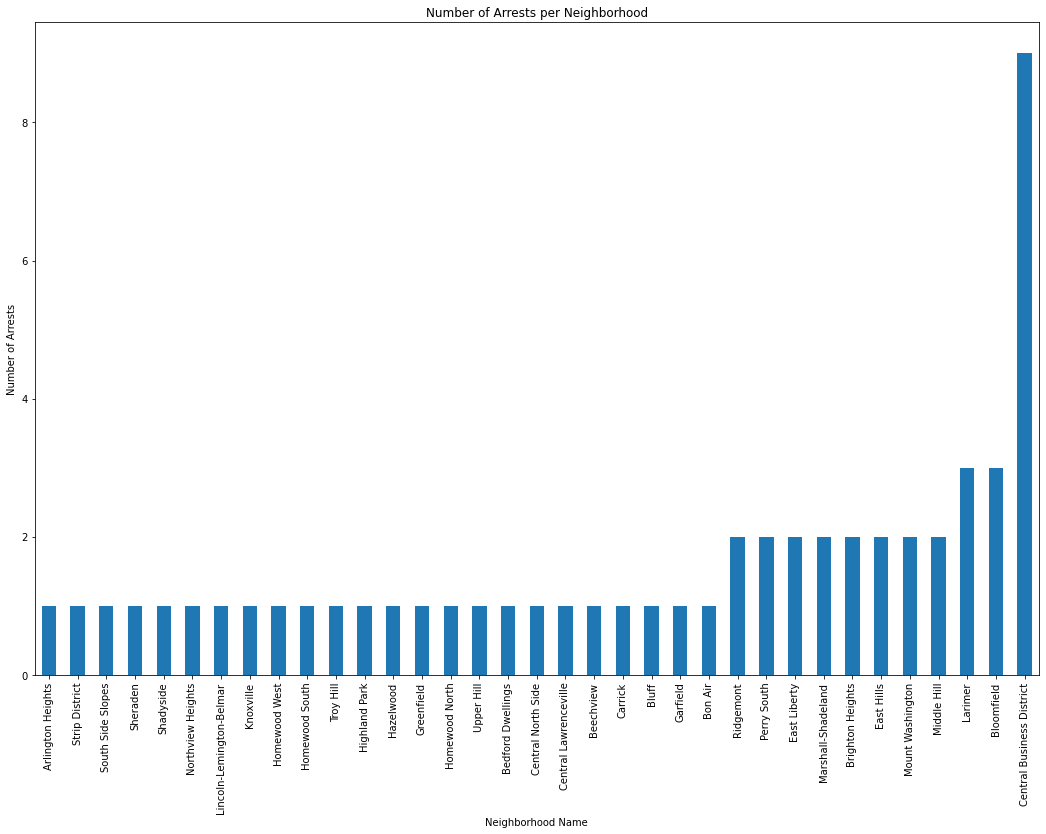

In [28]:
# get number of offenses per neighborhood
offenses_per_neighborhood = filtered_arrests.groupby("INCIDENTNEIGHBORHOOD").count().loc[:, "OFFENSES"]

# sort neighborhoods by number of offenses in ascending order
sorted_offenses_per_neighborhood = offenses_per_neighborhood.sort_values()

# create a bar plot
ax = sorted_offenses_per_neighborhood.plot.bar(figsize=(18, 12))

# add titles and labels
ax.set_title('Number of Arrests per Neighborhood')
ax.set_xlabel('Neighborhood Name')
ax.set_ylabel('Number of Arrests')

# angle neighborhood labels
plt.xticks(rotation=90)

# show the plot
plt.show()

This graph shows that, within the 30-day timeframe consistent with the `blotter` dataset, there are many neighborhoods tied with having only one or two arrests, and so we will need to augment our results with more data.

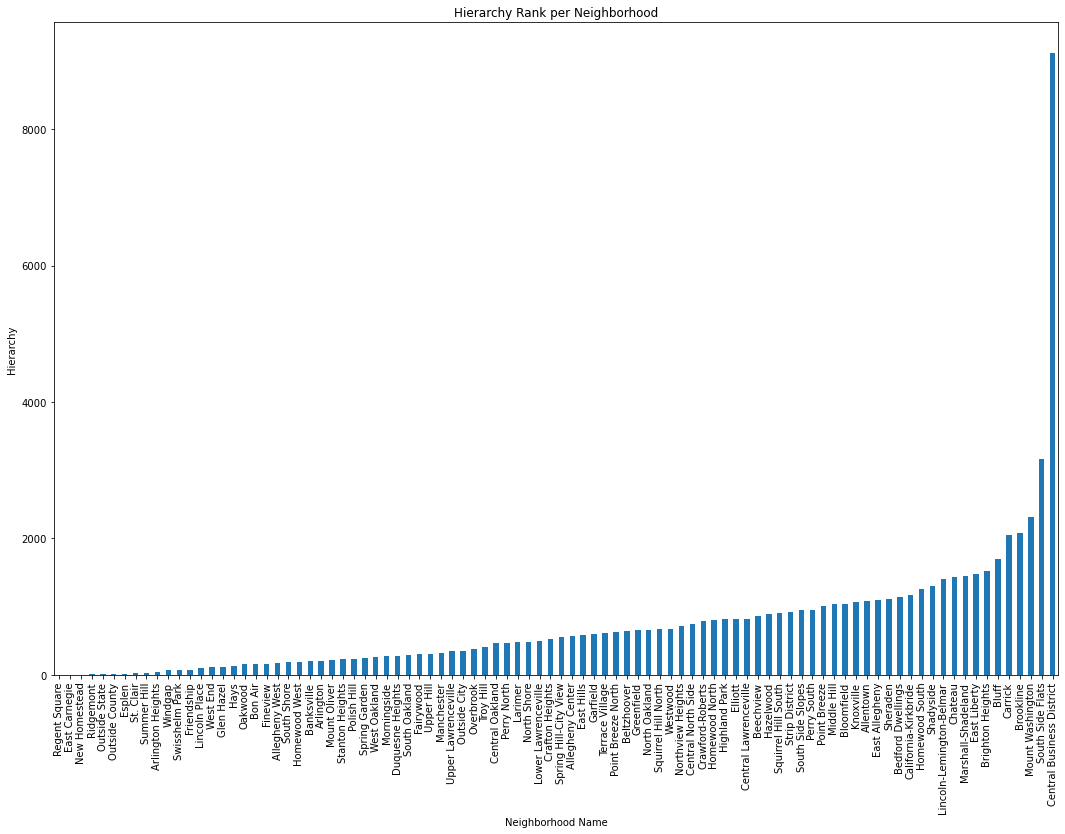

In [30]:
# create a bar plot
ax = rank.plot.bar(figsize = (18, 12))

# add titles and labels
ax.set_title('Hierarchy Rank per Neighborhood')
ax.set_xlabel('Neighborhood Name')
ax.set_ylabel('Hierarchy')

# angle neighborhood labels
plt.xticks(rotation=90)

# show the plot
plt.show()

We can also plot both sub-metrics on the same graph, but due to the vastly different scales of the sub-metrics this is not a particularly useful visualization.

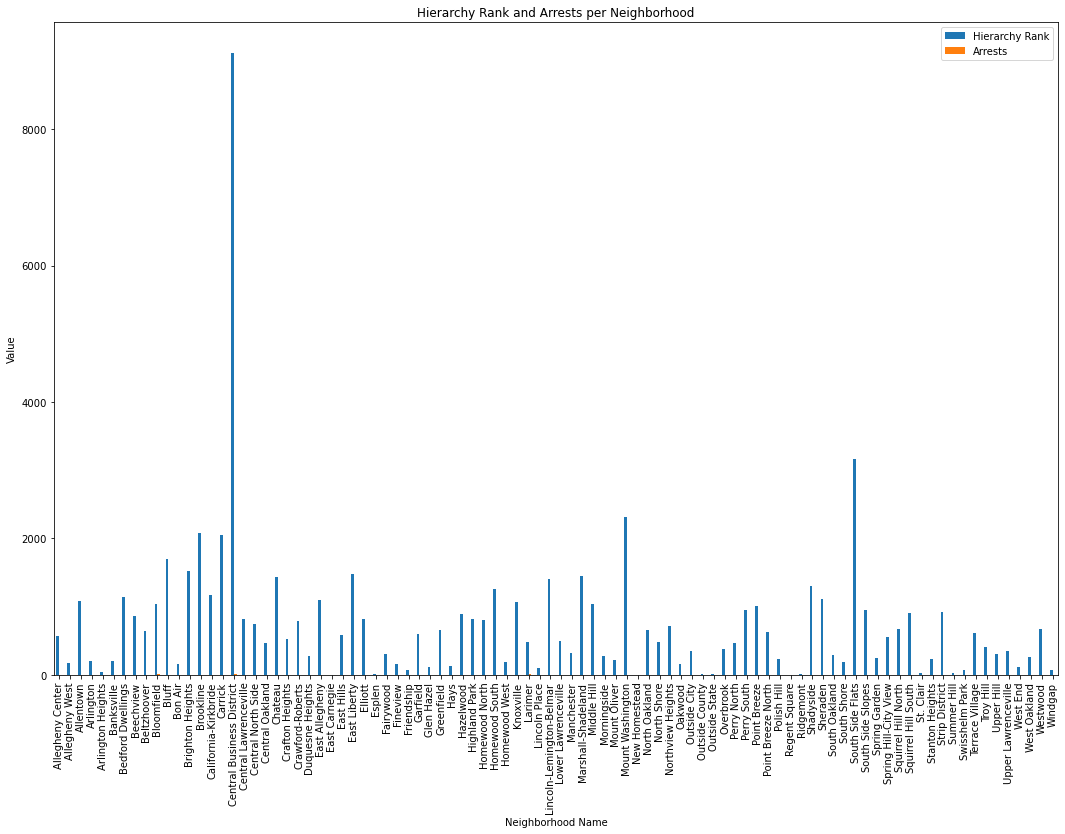

In [31]:
# Combine the Series into a single DataFrame
df = pd.DataFrame({'Hierarchy Rank': rank, 'Arrests': num_arrests})

# Plot the bar graph with both Series
ax = df.plot.bar(figsize = (18, 12))

# Customize the plot (optional)
ax.set_title('Hierarchy Rank and Arrests per Neighborhood')
ax.set_xlabel('Neighborhood Name')
ax.set_ylabel('Value')

# Show the plot
plt.show()